In [44]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

### 🧱 Lap Simulator Core Classes

This block defines the **core architecture** of the lap time simulator, modeling the physics and strategy of Formula 1-style racing.

#### ✅ Classes Defined:
- **`TrackSegment`**  
  Represents one sector of the track (either a corner or straight). Parameters include length, corner radius, grip, and type.

- **`Tire`**  
  Models thermal behavior, degradation, and compound effects. Supports:
  - Soft (high grip, fast degradation)
  - Medium (balanced)
  - Hard (low grip, slow degradation)

- **`Car`**  
  Includes mass, power, braking performance, and fuel mass, which is updated per lap to affect dynamic behavior.

- **`LapSimulator`**  
  Simulates each lap of the race by:
  - Calculating sector times based on current car and tire conditions
  - Applying degradation and heating logic
  - Handling **traffic penalties** from a car ahead
  - Triggering **pit stops** based on strategy (either at a set lap or when grip drops below a threshold)

#### 🔄 Lap Data Output:
Each lap returns a dictionary with:
- Total lap time
- Sector times
- Tire grip
- Car mass
- Compound type
- Pit stop flag

This forms the foundation for strategic lap time modeling and race comparison between cars.


In [54]:


class TrackSegment:
    def __init__(self, name, length_m, radius_m=None, grip_level=1.0, sector_type='straight'):
        self.name = name
        self.length = length_m
        self.radius = radius_m
        self.grip = grip_level          # 0–1 scale
        self.type = sector_type         # 'straight' or 'corner'


class Tire:
    def __init__(self, initial_grip=1.0, degradation_rate=0.02, optimal_temp=90, compound='soft'):
        compounds = {
            'soft': {"initial_grip": 1.0, 'degradation_rate': 0.015},
            'medium': {'initial_grip': 0.95, 'degradation_rate': 0.010},
            'hard': {'initial_grip': 0.9, 'degradation_rate':0.007}
        }
        config = compounds[compound]
        self.grip = config['initial_grip']
        self.degradation = config['degradation_rate']
        self.optimal_temp = optimal_temp
        self.temp = 70
        self.compound = compound
    def update(self, load, heating_rate=2.5, cooling_rate=1.0):
        # Simulate heating during high-load segments
        if load:
            self.temp += heating_rate
        else:
            self.temp -= cooling_rate
        self.temp = np.clip(self.temp, 40, 120)

        # Apply degradation based on temp deviation from optimum
        temp_factor = math.exp(-((self.temp - self.optimal_temp)**2) / 100)
        self.grip *= (1 - self.degradation * (1 - temp_factor))
        self.grip = max(self.grip, 0.5)  # clamp to avoid zero grip


class Car:
    def __init__(self, mass_kg, power_kw, braking_g=1.5, fuel_mass_start=100):
        self.mass = mass_kg
        self.power = power_kw
        self.braking_g = braking_g
        self.fuel_mass = fuel_mass_start

    def update_mass(self, fuel_burn_per_lap=2.5):
        self.fuel_mass = max(0, self.fuel_mass - fuel_burn_per_lap)
        return self.mass + self.fuel_mass


class LapSimulator:
    def __init__(self, car, tire, track):
        self.car = car
        self.tire = tire
        self.track = track
        self.lap_logs = []
        self.has_pitted = False

    def simulate_lap(self, car_ahead_sector_times=None, fuel_burn_per_lap=2.5, strategy=None):
        pit_time = 0
        sector_times = []
        lap_time = 0.0
        mass = self.car.update_mass(fuel_burn_per_lap)
        grip = self.tire.grip

        if strategy and not self.has_pitted:
          if strategy['type'] == 'lap' and len(self.lap_logs) + 1 == strategy['lap']:
            self.tire = Tire(compound=strategy['compound'])
            self.has_pitted = True
            pit_time = strategy.get('penalty', 20)
          elif strategy['type'] == 'grip' and self.tire.grip < strategy['threshold']:
            self.tire = Tire(compound=strategy['compound'])
            self.has_pitted = True
            pit_time = strategy.get('penalty', 20)
        lap_time = pit_time


        for i, seg in enumerate(self.track):
            if seg.type == 'straight':
                accel = self.car.power * 1000 / (mass * 9.81)
                time = seg.length / (accel * grip + 1e-5)
                self.tire.update(load=False)
            else:
                v_max = math.sqrt(seg.radius * 9.81 * grip * seg.grip)
                time = seg.length / v_max
                self.tire.update(load=True)
                if seg.radius < 70:
                    self.tire.grip *= 0.997

            # --- Traffic Logic ---
            if car_ahead_sector_times:
                gap = car_ahead_sector_times[i] - time
                if gap < 2.0 and seg.type == "corner":
                    penalty = random.uniform(0.3, 1.2)
                    time += penalty

            lap_time += time
            sector_times.append(time)

        lap_data = {
            "lap": len(self.lap_logs) + 1,
            "lap_time": lap_time,
            "sector_times": sector_times,
            "tire_grip": round(self.tire.grip, 4),
            "car_mass": round(mass, 2),
            "compound": self.tire.compound,
            "pit_stop": pit_time > 0
        }

        self.lap_logs.append(lap_data)
        return lap_data




### Test on one Car

In [38]:

test_track = [
    TrackSegment("Straight 1", length_m=300, sector_type='straight'),
    TrackSegment("Corner 1", length_m=100, radius_m=50, grip_level=0.9, sector_type='corner'),
    TrackSegment("Straight 2", length_m=400, sector_type='straight'),
    TrackSegment("Corner 2", length_m=120, radius_m=60, grip_level=0.95, sector_type='corner')
]



test_car = Car(mass_kg=800, power_kw=750, braking_g=1.5, fuel_mass_start=100)
test_tire = Tire(initial_grip=1.0, degradation_rate=0.01, optimal_temp=90)
simulator = LapSimulator(test_car, test_tire, test_track)


for _ in range(5):
    lap = simulator.simulate_lap()
    print(lap)



{'lap': 1, 'lap_time': 18.051673740636815, 'sector_times': [3.521789586566555, 4.759477076423548, 4.695719448755407, 5.074687628891306], 'tire_grip': 0.9549, 'car_mass': 897.5}
{'lap': 2, 'lap_time': 18.64604448537561, 'sector_times': [3.6780325425493197, 4.8706960946895865, 4.90404339006576, 5.193272458070947], 'tire_grip': 0.9118, 'car_mass': 895.0}
{'lap': 3, 'lap_time': 19.26121587481659, 'sector_times': [3.8409939179529196, 4.984395155221007, 5.121325223937226, 5.314501577705436], 'tire_grip': 0.8708, 'car_mass': 892.5}
{'lap': 4, 'lap_time': 19.895915508581897, 'sector_times': [4.010395655505811, 5.100272451981095, 5.347194207341082, 5.438053193753909], 'tire_grip': 0.8322, 'car_mass': 890.0}
{'lap': 5, 'lap_time': 20.544362355898777, 'sector_times': [4.184701924084962, 5.21726448915026, 5.579602565446616, 5.562793377216938], 'tire_grip': 0.7966, 'car_mass': 887.5}


### 📊 Lap Performance Visualization

This block generates two sets of visualizations to evaluate lap-by-lap vehicle performance and sector dynamics:

#### 🟦 1. Lap Time, Tire Grip, and Car Mass Plot
- Plots total lap time across all laps using primary Y-axis.
- Overlays tire grip and car mass using a secondary Y-axis to show how degradation and fuel burn affect performance.
- Highlights how tire wear and vehicle weight correlate with lap time.

#### 🔥 2. Sector Time Heatmap
- Converts sector-wise lap data into a heatmap.
- Each cell represents the time taken in a given sector on a specific lap.
- Visualizes sector consistency, performance drop-offs, and the impact of degradation or traffic in specific corners.

> Together, these visuals form a clear race engineer dashboard for analyzing both overall and micro-level performance trends.


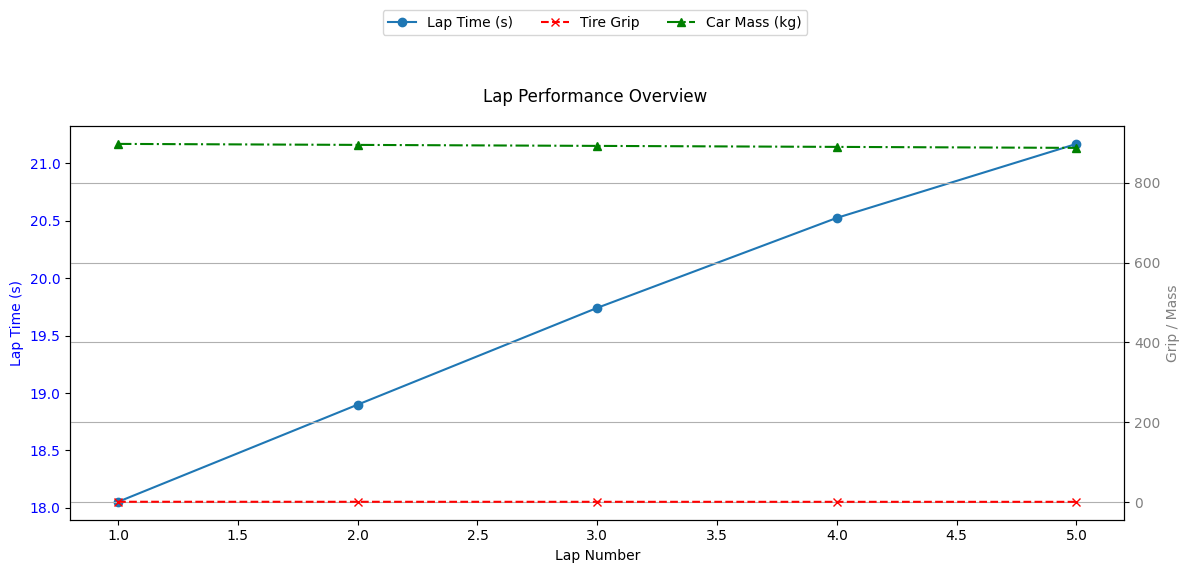

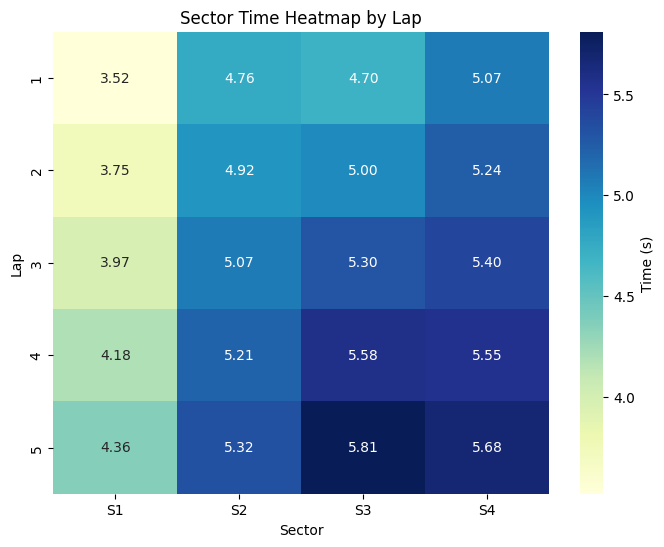

In [63]:
df = pd.DataFrame(simulator.lap_logs)
sector_df = pd.DataFrame(df['sector_times'].tolist(), columns=['S1', 'S2', 'S3', 'S4'])
sector_df['Lap'] = df['lap']

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(df['lap'], df['lap_time'], label='Lap Time (s)', marker='o')
ax1.set_xlabel('Lap Number')
ax1.set_ylabel('Lap Time (s)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df['lap'], df['tire_grip'], label='Tire Grip', color='red', linestyle='--', marker='x')
ax2.plot(df['lap'], df['car_mass'], label='Car Mass (kg)', color='green', linestyle='-.', marker='^')
ax2.set_ylabel("Grip / Mass", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

fig.suptitle("Lap Performance Overview")
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()


#heatmap
sector_melted = sector_df.melt(id_vars='Lap', var_name='Sector', value_name='Time (s)')
pivot = sector_melted.pivot(index="Lap", columns="Sector", values="Time (s)")
plt.figure(figsize=(8 , 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Time (s)'})
plt.title("Sector Time Heatmap by Lap")
plt.ylabel("Lap")
plt.xlabel("Sector")
plt.show()

### CSV Support for Track

In [62]:
def load_circuit_from_csv(path):
    df = pd.read_csv(path)
    track = []

    for _, row in df.iterrows():
        radius = None if pd.isna(row['radius_m']) else float(row['radius_m'])
        seg = TrackSegment(
            name=row['name'],
            length_m=float(row['length_m']),
            radius_m=radius,
            grip_level=float(row['grip_level']),
            sector_type=row['sector_type']
        )
        track.append(seg)

    return track

In [61]:
real_track = load_circuit_from_csv("circuit.csv")

# Run simulation on imported track
test_car = Car(mass_kg=800, power_kw=750, braking_g=1.5, fuel_mass_start=100)
test_tire = Tire(initial_grip=1.0, degradation_rate=0.01, optimal_temp=90)
simulator = LapSimulator(test_car, test_tire, real_track)

for _ in range(5):
    print(simulator.simulate_lap())

{'lap': 1, 'lap_time': 18.051673740636815, 'sector_times': [3.521789586566555, 4.759477076423548, 4.695719448755407, 5.074687628891306], 'tire_grip': 0.9374, 'car_mass': 897.5, 'compound': 'soft', 'pit_stop': False}
{'lap': 2, 'lap_time': 18.898402142989173, 'sector_times': [3.7463266616656625, 4.915707929739016, 4.995102215554216, 5.241265336030278], 'tire_grip': 0.8817, 'car_mass': 895.0, 'compound': 'soft', 'pit_stop': False}
{'lap': 3, 'lap_time': 19.741872955937815, 'sector_times': [3.972223133886846, 5.068827066397739, 5.2962975118491284, 5.404525243804103], 'tire_grip': 0.8347, 'car_mass': 892.5, 'compound': 'soft', 'pit_stop': False}
{'lap': 4, 'lap_time': 20.525715673243713, 'sector_times': [4.183736216155803, 5.209330532049379, 5.578314954874405, 5.554333970164126], 'tire_grip': 0.7991, 'car_mass': 890.0, 'compound': 'soft', 'pit_stop': False}
{'lap': 5, 'lap_time': 21.17033315130181, 'sector_times': [4.358183413597399, 5.324310108197076, 5.810911218129866, 5.676928411377473]

### 🏁 Multi-Car Race Simulation with Strategy & Overtake Modeling

This block runs a head-to-head simulation between **two cars** on the same track, each with a distinct strategy and physical configuration.

#### 🚗 Car Setup:
- **Car 1**: Slightly lighter and more powerful; switches to **medium tires** on Lap 3.
- **Car 2**: Heavier and slower; uses a **grip-threshold strategy** to switch to hard tires when tire performance drops.

#### 🛠️ Strategy Features:
- **Lap-based pit stop** (Car 1): Forces a compound change at a predefined lap with a 20-second pit penalty.
- **Grip-based pit stop** (Car 2): Automatically triggers a pit stop if grip drops below 0.85, with a 22-second penalty.

#### 🧠 Traffic and Overtake Logic:
- If Car 2 finishes a lap **0.5s faster** than Car 1, it is considered to have overtaken.
- Position updates are recorded per lap to simulate race dynamics.

#### 🧾 Output:
- Lap-by-lap comparison of lap times and compounds used
- Realistic pit stop impact simulation
- Position leaderboard updated every lap

> This block emulates real race strategy decisions and traffic-influenced performance, giving a complete picture of how tire management and timing decisions affect race outcome.


In [57]:
# 2 Different Cars

# Setup: define 2 different cars
car_1 = Car(mass_kg=795, power_kw=760, braking_g=1.6, fuel_mass_start=95)
car_2 = Car(mass_kg=810, power_kw=740, braking_g=1.5, fuel_mass_start=100)

strategy_1 = {'type': 'lap', 'lap': 3, 'compound': 'medium', 'penalty': 20}
strategy_2 = {'type': 'grip', 'threshold': 0.85, 'compound': 'hard', 'penalty': 22}

car_1 = Car(mass_kg=795, power_kw=760, braking_g=1.6, fuel_mass_start=95)
car_2 = Car(mass_kg=810, power_kw=740, braking_g=1.5, fuel_mass_start=100)

tire_1 = Tire(compound='soft')
tire_2 = Tire(compound='soft')

sim_1 = LapSimulator(car_1, tire_1, real_track)
sim_2 = LapSimulator(car_2, tire_2, real_track)


positions = []

for lap in range(5):      # can change number of laps from '5'
    car1_data = sim_1.simulate_lap(strategy=strategy_1)
    car2_data = sim_2.simulate_lap(car_ahead_sector_times=car1_data['sector_times'], strategy=strategy_2)


    if car2_data['lap_time'] + 0.5 < car1_data['lap_time']:
        lead = "Car 2"
    else:
        lead = "Car 1"

    positions.append(lead)

    print(f"Lap {lap+1}")
    print(f"🏎️ Car 1: {car1_data['lap_time']:.2f}s (compound: {car1_data['compound']})")
    print(f"🚗 Car 2: {car2_data['lap_time']:.2f}s (compound: {car2_data['compound']})")
    print(f"🔁 Lead: {lead}\n")
    if car1_data['pit_stop'] or car2_data['pit_stop']:
        print(f"🛠️ Pit stop occurred\n")


print("🏁 Position per lap:", positions)



Lap 1
🏎️ Car 1: 17.85s (compound: soft)
🚗 Car 2: 19.41s (compound: soft)
🔁 Lead: Car 1

Lap 2
🏎️ Car 1: 18.69s (compound: soft)
🚗 Car 2: 20.46s (compound: soft)
🔁 Lead: Car 1

Lap 3
🏎️ Car 1: 39.52s (compound: medium)
🚗 Car 2: 21.91s (compound: soft)
🔁 Lead: Car 2

🛠️ Pit stop occurred

Lap 4
🏎️ Car 1: 19.07s (compound: medium)
🚗 Car 2: 44.52s (compound: hard)
🔁 Lead: Car 1

🛠️ Pit stop occurred

Lap 5
🏎️ Car 1: 19.65s (compound: medium)
🚗 Car 2: 22.34s (compound: hard)
🔁 Lead: Car 1

🏁 Position per lap: ['Car 1', 'Car 1', 'Car 2', 'Car 1', 'Car 1']


### Relevant Plots

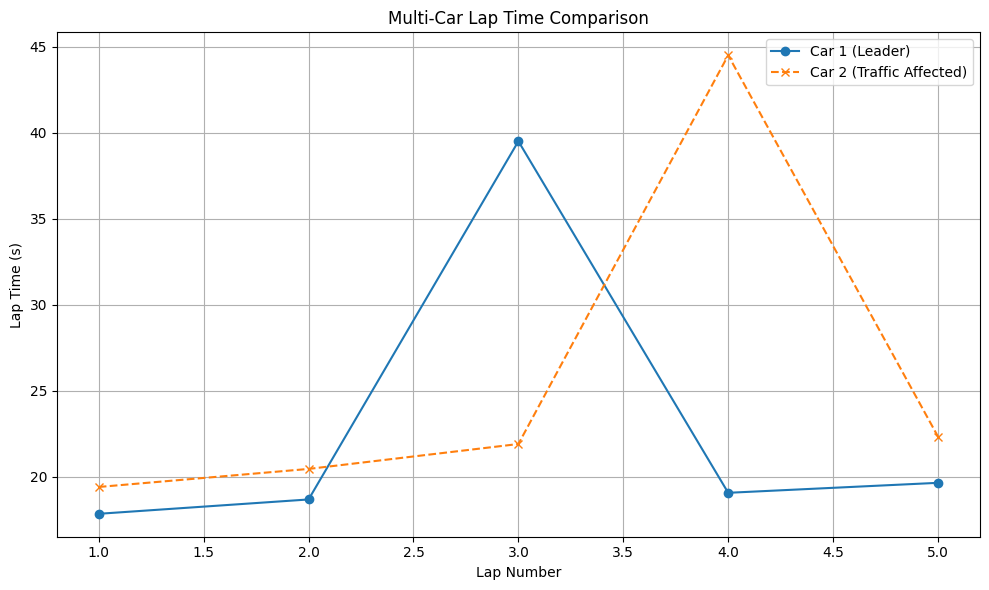

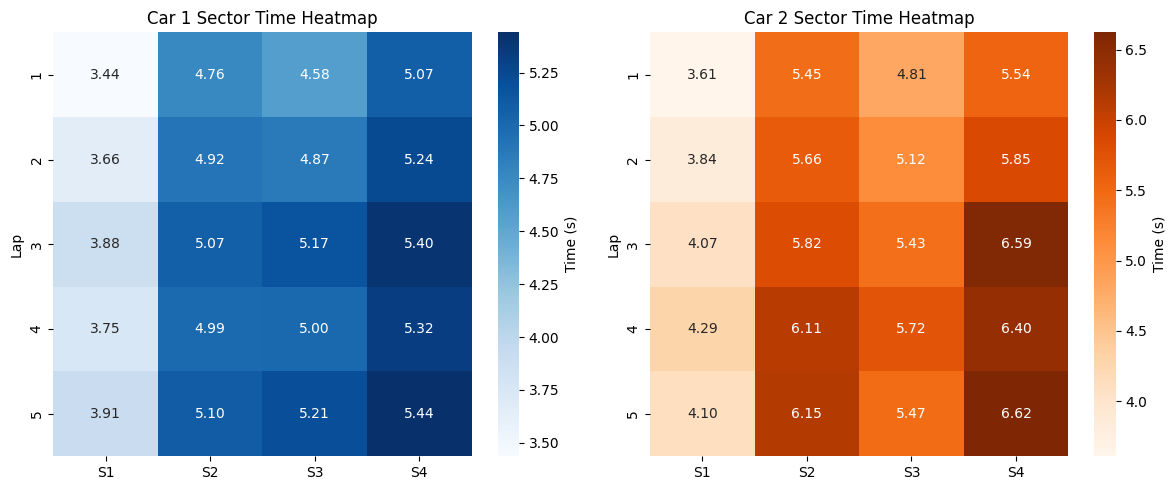

In [58]:
#side-by-side comparisions

import matplotlib.pyplot as plt
import pandas as pd

df1 = pd.DataFrame(sim_1.lap_logs)
df2 = pd.DataFrame(sim_2.lap_logs)

plt.figure(figsize=(10, 6))
plt.plot(df1['lap'], df1['lap_time'], label='Car 1 (Leader)', marker='o', linestyle='-')
plt.plot(df2['lap'], df2['lap_time'], label='Car 2 (Traffic Affected)', marker='x', linestyle='--')

plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.title("Multi-Car Lap Time Comparison")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

df_car1 = pd.DataFrame([lap['sector_times'] for lap in sim_1.lap_logs], columns=['S1', 'S2', 'S3', 'S4'])
df_car1['Lap'] = [lap['lap'] for lap in sim_1.lap_logs]
df_car1 = df_car1.set_index('Lap')

df_car2 = pd.DataFrame([lap['sector_times'] for lap in sim_2.lap_logs], columns=['S1', 'S2', 'S3', 'S4'])
df_car2['Lap'] = [lap['lap'] for lap in sim_2.lap_logs]
df_car2 = df_car2.set_index('Lap')

# Plot side-by-side heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(df_car1, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Time (s)'})
plt.title("Car 1 Sector Time Heatmap")

plt.subplot(1, 2, 2)
sns.heatmap(df_car2, annot=True, fmt=".2f", cmap="Oranges", cbar_kws={'label': 'Time (s)'})
plt.title("Car 2 Sector Time Heatmap")

plt.tight_layout()
plt.show()

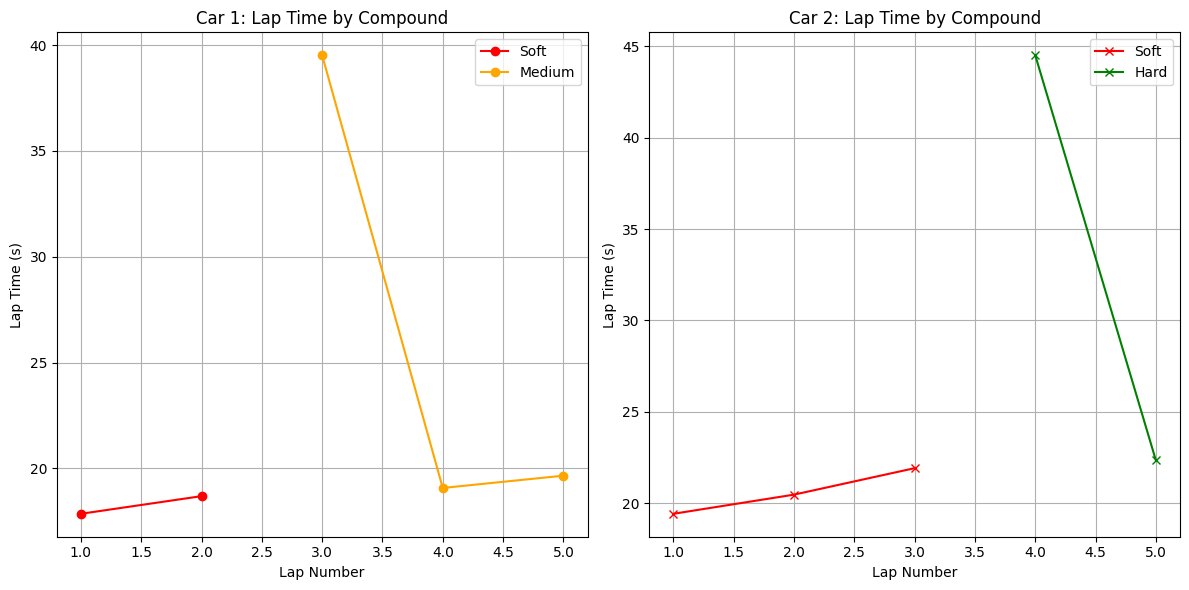

In [64]:



df1 = pd.DataFrame(sim_1.lap_logs)
df2 = pd.DataFrame(sim_2.lap_logs)


colors = {'soft': 'red', 'medium': 'orange', 'hard': 'green'}


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
for compound in df1['compound'].unique():
    subset = df1[df1['compound'] == compound]
    plt.plot(subset['lap'], subset['lap_time'], marker='o', label=f"{compound.title()}", color=colors.get(compound, 'gray'))
plt.title("Car 1: Lap Time by Compound")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)
for compound in df2['compound'].unique():
    subset = df2[df2['compound'] == compound]
    plt.plot(subset['lap'], subset['lap_time'], marker='x', label=f"{compound.title()}", color=colors.get(compound, 'gray'))
plt.title("Car 2: Lap Time by Compound")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
